<h1 align="center" style="color:blue;font-size:2.5em">✨期中大作业✨</h1>
<p align="right" style="color:orange;font-size:1.5em">————黄金、铂金价格比率与中国股票市场的相关性与预测能力研究</p>

陈进益、白皓然、高欣

In [59]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置列不限制数量
pd.set_option('display.max_columns', None)

<font size="4" color=#1e66eaff>✨计算公式✨</font> 
- $GP_t = \ln\left(\frac{AU(T+D)_{t}}{PT9995_{t}}\right) - \ln\left(\frac{AU(T+D)_{t-1}}{PT9995_{t-1}}\right)$

In [60]:
gold = pd.read_csv('./CGM_Shgtrd.csv')
#先把下载的上海黄金及贵重金属日交易文件我们需要的数据提出，
# 黄金价格选择上海黄金交易所黄金现货每日结算价:Au(T+D)，
# 铂金价格选择上海黄金交易所铂金现货每日收盘价(Pt9995)。
gold = gold[(gold['Goldtype'] == 'AU(T+D)') | (gold['Goldtype'] == 'PT9995')]   
gold = gold.rename(columns={'Trddt': 'Day'}) #修改列名
gold = gold.pivot_table(index='Day', columns='Goldtype', values='Clsprcd') #重建行索引
#输出了一次发现早年金数据缺失，从AU(T+D)有值开始
gold.index = pd.to_datetime(gold.index)
gold = gold.sort_index()
start_date = gold['AU(T+D)'].first_valid_index() #first_valid_index()实现找到第一个不为缺失值的
end_date = pd.to_datetime('2025-08-29')
gold = gold.loc[start_date:end_date]


#根据 ln(AU(T+D)/PT9995) 的一阶差分计算 GP黄金、铂金价格比率的变动率序列
gold['GP'] = np.log(gold['AU(T+D)'] / gold['PT9995']).diff()  #用于计算时间序列数据中当前元素与前一个元素的差值。
# 查看结果
gold


Goldtype,AU(T+D),PT9995,GP
Day,,,
2004-09-01,108.49,238.15,NaN
2004-09-02,108.35,240.11,-0.009488
2004-09-03,NaN,237.92,NaN
2004-09-06,NaN,233.25,NaN
2004-09-07,107.35,234.50,NaN
...,...,...,...
2025-08-25,775.34,322.67,-0.001328
2025-08-26,776.83,318.40,0.015242
2025-08-27,777.62,321.36,-0.008237


In [61]:
data = pd.read_csv('./000001.csv')
data['Day'] = pd.to_datetime(data['Day'],format='%Y/%m/%d') #更改Day列格式为XXXX-XX-XX
data.set_index('Day', inplace = True) #重建行索引为Day列
data.sort_values(by = ['Day'], ascending=True) #Day列升序排序


,Preclose,Open,Highest,Lowest,Close
Day,,,,,
1990-12-19,,96.050,99.980,95.790,99.980
1990-12-20,99.98,104.300,104.390,99.980,104.390
1990-12-21,104.39,109.070,109.130,103.730,109.130
1990-12-24,109.13,113.570,114.550,109.130,114.550
1990-12-25,114.55,120.090,120.250,114.550,120.250
...,...,...,...,...,...
2025-08-25,3825.759,3848.163,3883.562,3839.972,3883.562
2025-08-26,3883.562,3871.471,3888.599,3859.758,3868.382
2025-08-27,3868.382,3869.612,3887.198,3800.350,3800.350


股票的收益率的计算一般使用的是**收盘价**来计算   
常用收盘价来计算收益率：收盘价通常是收盘集合竞价的结果，<font size="4" color=#e64500ff>避免前瞻性偏差</font>  
- Log Return: $r_t = \ln(p_t) - \ln(p_{t-1})$  
<font size="5" color= #16b75eff>对数收益率和原始收益率的区别</font>  
- <font size="4" color=#e64500ff>**原始收益率**</font>关注实际资金变化，用于计算投资组合的最终真实价值、绩效指标和涉及现金流的计算。      
- <font size="4" color=#e64500ff>**对数收益率**</font>关注数学便利和统计性质，用于金融建模、理论研究、时间序列分析和量化策略研发。  


In [62]:
#我们用对数收益率试试
data_new = data['2004-09-01':'2025-08-29'].copy()
data_new['Close'] = pd.to_numeric(data_new['Close'])
data_new['Preclose'] = pd.to_numeric(data_new['Preclose'])
# 计算000001上证指数日收益率
data_new['Log_return'] = np.log(data_new['Close']) - np.log(data_new['Preclose'])
data_new

,Preclose,Open,Highest,Lowest,Close,Log_return
Day,,,,,,
2004-09-01,1342.060,1340.750,1340.770,1319.860,1321.460,-0.015469
2004-09-02,1321.460,1319.070,1328.610,1303.190,1327.930,0.004884
2004-09-03,1327.930,1327.810,1333.220,1319.830,1327.120,-0.000610
2004-09-06,1327.120,1326.460,1326.870,1315.960,1321.460,-0.004274
2004-09-07,1321.460,1321.210,1325.680,1312.310,1324.290,0.002139
...,...,...,...,...,...,...
2025-08-25,3825.759,3848.163,3883.562,3839.972,3883.562,0.014996
2025-08-26,3883.562,3871.471,3888.599,3859.758,3868.382,-0.003916
2025-08-27,3868.382,3869.612,3887.198,3800.350,3800.350,-0.017743


Text(0.5, 0, 'Date')

Text(0, 0.5, '价格（人民币/克）')

Text(0, 0.5, 'Ret_log')

Text(0.5, 0.98, '月度 Ret_log、黄金 AU(T+D) 与 铂金 PT9995 三曲线对比')

,Ret_log,AU(T+D),PreAU,AuReturn,PT9995,PrePt,PtReturn
Day,,,,,,,
2004-09-30,0.039907,108.73,108.73,0.000000,235.10,235.42,-0.001359
2004-11-30,0.015203,119.07,118.92,0.001261,237.29,236.16,0.004785
2004-12-31,-0.056987,116.94,116.10,0.007235,235.30,235.83,-0.002247
2005-01-31,-0.060776,113.10,113.53,-0.003788,238.10,237.96,0.000588
2005-02-28,0.091487,116.38,115.80,0.005009,239.32,236.70,0.011069


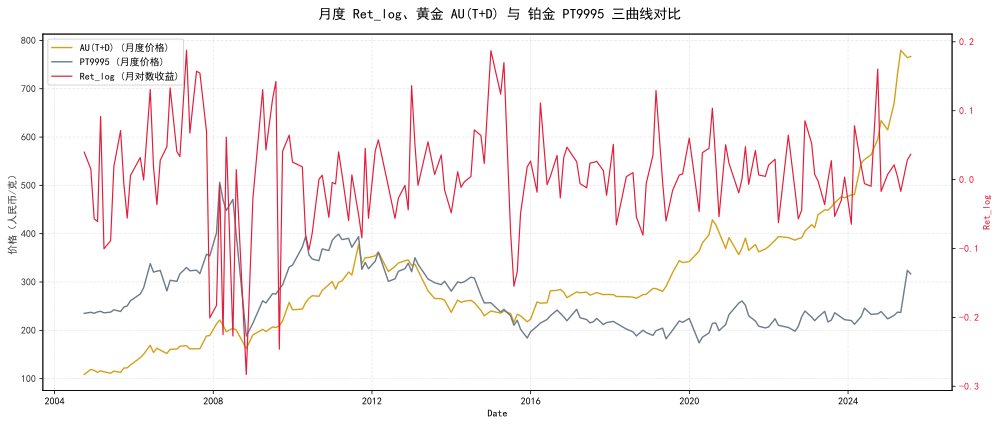

In [63]:
#月度数据
Month_data = data_new.resample('ME')['Log_return'].sum().to_frame(name='Ret_log') #股票数据，累加


Month_Gold = gold['AU(T+D)'].resample('ME').last().to_frame(name='AU(T+D)')# .to_frame保证 Month_Gold 为 DataFrame
Month_Gold['PreAU']=gold['AU(T+D)'].shift(1)
Month_Gold['AuReturn']=(Month_Gold['AU(T+D)']/Month_Gold['PreAU'])-1



Month_Pt = gold['PT9995'].resample('ME').last().to_frame(name='PT9995')
Month_Pt['PrePt']=gold['PT9995'].shift(1)
Month_Pt['PtReturn']=(Month_Pt['PT9995']/Month_Pt['PrePt'])-1
#作图
monthly_plot_df = Month_data.join([Month_Gold, Month_Pt], how='inner').dropna()
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置中文字体
plt.rcParams['axes.unicode_minus'] = False  #解决负号问题
fig, ax_left = plt.subplots(figsize=(14, 6))
color_gold = '#d4a017'
color_pt = '#6c7a89'
color_ret = '#e31e3b'

line_gold, = ax_left.plot(monthly_plot_df.index, monthly_plot_df['AU(T+D)'], color=color_gold, linewidth=1.4, label='AU(T+D) (月度价格)')
line_pt, = ax_left.plot(monthly_plot_df.index, monthly_plot_df['PT9995'], color=color_pt, linewidth=1.4, label='PT9995 (月度价格)')
ax_left.set_xlabel('Date')
ax_left.set_ylabel('价格（人民币/克）', color='#333333')
ax_left.tick_params(axis='y', labelcolor='#333333')
ax_left.grid(True, linestyle='--', alpha=0.3)

ax_right = ax_left.twinx()
line_ret, = ax_right.plot(monthly_plot_df.index, monthly_plot_df['Ret_log'], color=color_ret, linewidth=1.2, label='Ret_log (月对数收益)')
ax_right.set_ylabel('Ret_log', color=color_ret)
ax_right.tick_params(axis='y', labelcolor=color_ret)

lines = [line_gold, line_pt, line_ret]
labels = [l.get_label() for l in lines]
ax_left.legend(lines, labels, loc='upper left')
fig.suptitle('月度 Ret_log、黄金 AU(T+D) 与 铂金 PT9995 三曲线对比', fontsize=14)

plt.tight_layout()
monthly_plot_df.head() #合并了Ret_log、AuReturn、PtReturn

In [64]:
from statsmodels.tsa.stattools import adfuller as ADF
import numpy as np
au_return_clean = Month_Gold['AuReturn'].replace([np.inf, -np.inf], np.nan).dropna()
# 对清理后的数据进行ADF检验
adf_result = ADF(au_return_clean)  # 这里要传入具体的列数据

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f' {key}: {value:.4f}')

if adf_result[1] < 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -12.5100
p-value: 0.0000
Critical Values:
 1%: -3.4701
 5%: -2.8790
 10%: -2.5761
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [65]:
#开始拟合月度数据（lAuReturn滞后一期）
monthly_reg = monthly_plot_df[['Ret_log','AuReturn']].copy()
monthly_reg['lAuReturn'] = monthly_reg['AuReturn'].shift(1)
monthly_reg = monthly_reg['2004-09-30':'2025-08-31'].dropna()
model_cpi = smf.ols('Ret_log ~ lAuReturn',                      #smf.ols()调用包，'被解释变量 ~ 解释变量'
                 data=monthly_reg).fit(              #数据是什么，.fit拟合，cov_type='HAC', cov_kwds={'maxlags': 6}处理时间序列数据存在自相关或异方差问题
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())
#===== 回归结果主要结论 =====
#1. 模型整体不显著：F统计量p值=0.587 > 0.1，模型整体不显著
#2. 滞后黄金收益率不显著：lAuReturn系数=-0.3593，p值=0.587 > 0.1，统计上不显著
#- 滞后一期黄金收益率变动对股票收益率无显著预测能力
#3. 截距项不显著：截距系数=0.0053，p值=0.433，统计上不显著
#4. 模型解释力极弱：R²=0.002，调整后R²=-0.004，模型几乎无解释力

                            OLS Regression Results                            
Dep. Variable:                Ret_log   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2970
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.587
Time:                        00:09:12   Log-Likelihood:                 195.54
No. Observations:                 167   AIC:                            -387.1
Df Residuals:                     165   BIC:                            -380.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0053      0.007      0.784      0.4

In [66]:
#开始拟合月度数据（PtReturn滞后一期）
monthly_reg = monthly_plot_df[['Ret_log','PtReturn']].copy()
monthly_reg['lPtReturn'] = monthly_reg['PtReturn'].shift(1)
monthly_reg = monthly_reg['2004-09-30':'2025-08-31'].dropna()
model_cpi = smf.ols('Ret_log ~ lPtReturn',                      #smf.ols()调用包，'被解释变量 ~ 解释变量'
                 data=monthly_reg).fit(              #数据是什么，.fit拟合，cov_type='HAC', cov_kwds={'maxlags': 6}处理时间序列数据存在自相关或异方差问题
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())

#===== 回归结果主要结论 =====
#1. 模型整体不显著：F统计量p值=0.210 > 0.1，模型整体不显著
#2. 滞后铂金收益率不显著：lptReturn系数=-0.5489，p值=0.209 > 0.1，统计上不显著
#- 滞后一期铂金收益率变动对股票收益率无显著预测能力
#3. 截距项不显著：截距系数=0.0049，p值=0.473 > 0.1，统计上不显著
#4. 模型解释力极弱：R²=0.007，调整后R²=0.001，模型几乎无解释力

                            OLS Regression Results                            
Dep. Variable:                Ret_log   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.582
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.210
Time:                        00:09:12   Log-Likelihood:                 195.99
No. Observations:                 167   AIC:                            -388.0
Df Residuals:                     165   BIC:                            -381.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0049      0.007      0.717      0.4

In [67]:
#季度数据
Quarter_data = data_new.resample('QE')['Log_return'].sum().to_frame(name='Ret_log') #累加
Quarter_data

Quarter_Gold = gold['AU(T+D)'].resample('QE').last().to_frame(name='AU(T+D)')# .to_frame保证 Month_Gold 为 DataFrame（季度均值）
Quarter_Gold

Quarter_Pt = gold['PT9995'].resample('QE').last().to_frame(name='PT9995')
Quarter_Pt

,Ret_log
Day,
2004-09-30,0.039907
2004-12-31,-0.097855
2005-03-31,-0.069692
2005-06-30,-0.088734
2005-09-30,0.066797
...,...
2024-09-30,0.117234
2024-12-31,0.004565
2025-03-31,-0.004790


,AU(T+D)
Day,
2004-09-30,108.73
2004-12-31,116.94
2005-03-31,114.20
2005-06-30,115.54
2005-09-30,121.95
...,...
2024-09-30,595.22
2024-12-31,614.82
2025-03-31,730.08


,PT9995
Day,
2004-09-30,235.10
2004-12-31,235.30
2005-03-31,236.13
2005-06-30,242.45
2005-09-30,248.08
...,...
2024-09-30,234.05
2024-12-31,223.77
2025-03-31,237.66


<font size="4" color=#1e66eaff>✨日度数据✨</font> 

Text(0.5, 0, 'Date')

Text(0, 0.5, 'GP (daily)')

Text(0, 0.5, 'Ret_log (daily)')

Text(0.5, 0.98, '日度 GP 与 日度 Ret_log')

,GP,Log_return
Day,,
2004-09-02,-0.009488,0.004884
2004-09-08,0.007282,-0.011361
2004-09-09,0.010750,-0.019294
2004-09-10,-0.002334,0.002154
2004-09-13,0.005307,-0.021010


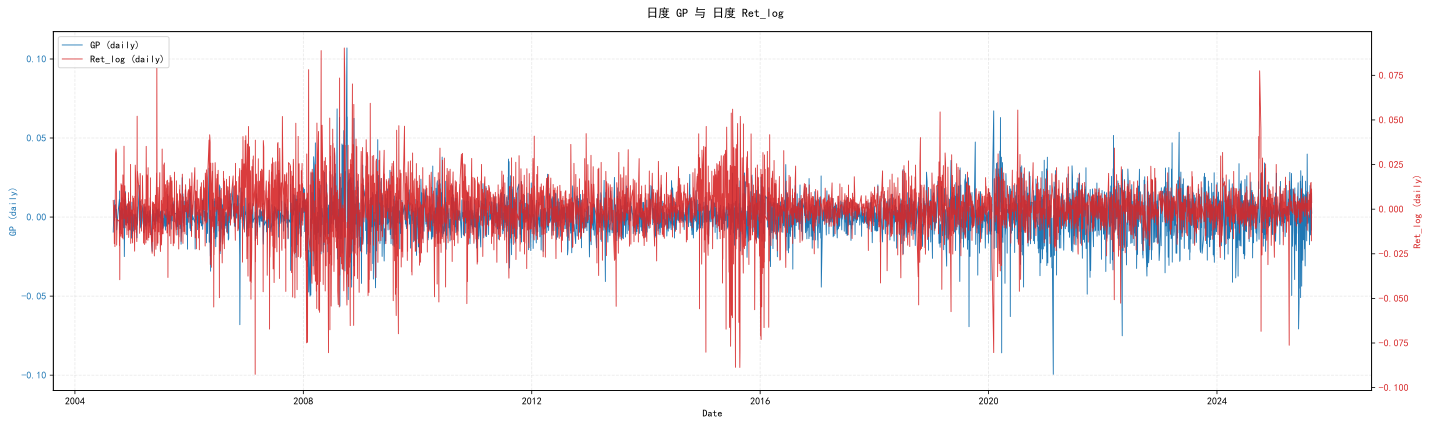

In [68]:
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置中文字体
plt.rcParams['axes.unicode_minus'] = False  #解决负号问题
# 日度数据：对齐 GP（日度）与 上证指数日对数收益（Log_return），并绘制双 y 轴图
# 处理方式：取交集并去缺失

daily_ret = data_new[['Log_return']].copy()
daily_gp = gold[['GP']].copy()
#合并GP、Log_return
daily_aligned = daily_gp.join(daily_ret, how='inner').dropna()


fig, ax_left = plt.subplots(figsize=(20, 6))
color_left = '#1f77b4'
color_right = '#d62728'

line_l, = ax_left.plot(daily_aligned.index, daily_aligned['GP'], color=color_left, linewidth=0.9, label='GP (daily)')
ax_left.set_xlabel('Date')
ax_left.set_ylabel('GP (daily)', color=color_left)
ax_left.tick_params(axis='y', labelcolor=color_left)
ax_left.grid(True, linestyle='--', alpha=0.3)

ax_right = ax_left.twinx()
line_r, = ax_right.plot(daily_aligned.index, daily_aligned['Log_return'], color=color_right, linewidth=0.9, alpha=0.9, label='Ret_log (daily)')
ax_right.set_ylabel('Ret_log (daily)', color=color_right)
ax_right.tick_params(axis='y', labelcolor=color_right)

fig.suptitle('日度 GP 与 日度 Ret_log')
ax_left.legend([line_l, line_r], ['GP (daily)', 'Ret_log (daily)'], loc='upper left')
fig.savefig('图/dailyGPandRet_log.pdf', bbox_inches='tight')
plt.tight_layout()
daily_aligned.head()

In [69]:
daily_aligned[['GP','Log_return']].describe().round(5)

,GP,Log_return
count,4996.00000,4996.00000
mean,0.00035,0.00015
std,0.01169,0.01483
min,-0.09946,-0.09256
25%,-0.00534,-0.00607
50%,0.00029,0.00054
75%,0.00632,0.00707
max,0.10696,0.09034


Text(0.5, 1.0, 'GP 日度偏度分布')

Text(0.5, 0, '数值')

Text(0, 0.5, '频数')

Text(0.02, 0.95, '负偏度（左偏）')

Text(0.02, 0.9, '偏度值 ≈ -0.18')

,GP
count,4996.000000
mean,0.000353
std,0.011695
min,-0.099456
25%,-0.005344
50%,0.000294
75%,0.006316
max,0.106960


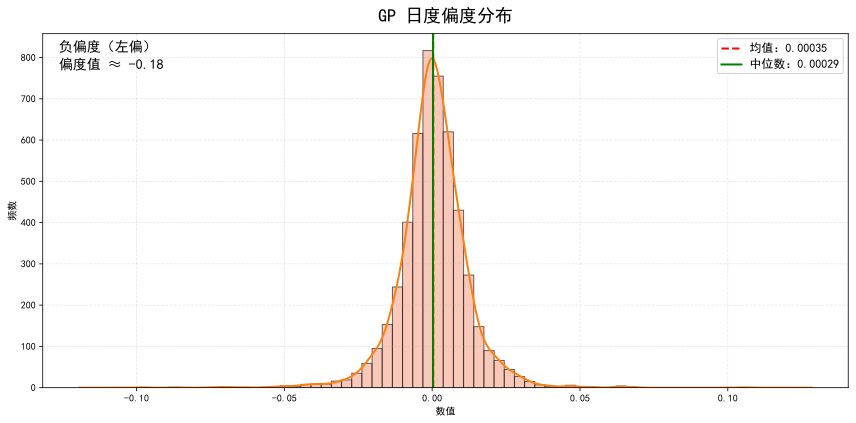

In [70]:
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置中文字体
plt.rcParams['axes.unicode_minus'] = False  #解决负号问题
# 日度数据偏度图（示例：Ret_log 日度）
from scipy import stats
import numpy as np

# 选择要分析的日度序列：'Log_return' 或 'GP'
series_name = 'GP'   # 可改为 'GP' 'Log_return'
ser = daily_aligned[series_name].dropna().astype(float)

mu = ser.mean()
med = ser.median()
skew_val = stats.skew(ser, bias=False)

fig, ax = plt.subplots(figsize=(12, 6))

# 直方图
n, bins, patches = ax.hist(ser, bins=60, color='#f7a38a', edgecolor='black', alpha=0.6)

# KDE 曲线
kde = stats.gaussian_kde(ser)
x_eval = np.linspace(ser.min()*1.2, ser.max()*1.2, 400)
ax.plot(x_eval, kde(x_eval) * (len(ser) * (bins[1]-bins[0])), color='#ff7f0e', linewidth=2)

# 均值/中位数垂线
ax.axvline(mu, color='red', linestyle='--', linewidth=2, label=f'均值：{mu:.5f}')
ax.axvline(med, color='green', linestyle='-', linewidth=2, label=f'中位数：{med:.5f}')

# 文本与样式
pos = '正偏度（右偏）' if skew_val > 0 else '负偏度（左偏）'
ax.set_title(f'{series_name} 日度偏度分布', fontsize=18, pad=12)
ax.set_xlabel('数值')
ax.set_ylabel('频数')

# 角标信息
ax.text(0.02, 0.95, pos, transform=ax.transAxes, fontsize=14)
ax.text(0.02, 0.90, f'偏度值 ≈ {skew_val:.2f}', transform=ax.transAxes, fontsize=14)

# 图例区域（模仿截图样式）
legend = ax.legend(framealpha=0.9, loc='upper right')
for txt in legend.get_texts():
    txt.set_fontsize(12)

ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
ser.describe().to_frame(name=series_name)
fig.savefig('图/GPpiandu.pdf', bbox_inches='tight')


In [71]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月对数收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(daily_aligned['Log_return'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -16.8084
p-value: 0.0000
Critical Values:
   1%: -3.4317
   5%: -2.8621
   10%: -2.5671
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [72]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月对数收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(daily_aligned['GP'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -47.1221
p-value: 0.0000
Critical Values:
   1%: -3.4317
   5%: -2.8621
   10%: -2.5671
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


<font size="6" color=#87CEEB>✨OLS 回归结果✨</font>  

In [73]:
#开始拟合日度数据（GP滞后一期）
daily_reg = daily_aligned[['Log_return','GP']].copy()
daily_reg['lGP'] = daily_reg['GP'].shift(1)
daily_reg = daily_reg['2004-09-30':'2025-08-31'].dropna()
model_cpi = smf.ols('Log_return ~ lGP',                      #smf.ols()调用包，'被解释变量 ~ 解释变量'
                 data=daily_reg).fit(              #数据是什么，.fit拟合，cov_type='HAC', cov_kwds={'maxlags': 6}处理时间序列数据存在自相关或异方差问题
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())
#===== 回归结果主要结论 =====
#1. 模型整体不显著：F统计量p值=0.194 > 0.1，模型整体不显著
#2. 滞后黄金铂金价格比率不显著：IGP系数=0.0259，p值=0.194 > 0.1，统计上不显著
#- 滞后一期黄金铂金价格比率变动对股票日收益率无显著预测能力

                            OLS Regression Results                            
Dep. Variable:             Log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.688
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.194
Time:                        00:09:14   Log-Likelihood:                 13929.
No. Observations:                4986   AIC:                        -2.785e+04
Df Residuals:                    4984   BIC:                        -2.784e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      0.612      0.5

<font size="4" color=#1e66eaff>✨月度数据✨</font> 

In [74]:
# 计算月度 GP：对日度 GP 累加（等价于当月 ln(黄金/铂金) 的变动）
gp_month = gold['GP'].resample('ME').sum().to_frame(name='GP')

# 与月度上证指数 Ret_log 对齐（取交集并去缺失）
aligned = gp_month.join(Month_data, how='inner').dropna()
aligned

,GP,Ret_log
Day,,
2004-09-30,0.012657,0.039907
2004-10-31,0.042722,-0.056072
2004-11-30,0.018222,0.015203
2004-12-31,-0.009629,-0.056987
2005-01-31,-0.045218,-0.060776
...,...,...
2025-04-30,0.068280,-0.017148
2025-05-31,-0.090782,0.020662
2025-06-30,-0.242068,0.028547


Text(0.5, 0, 'Date')

Text(0, 0.5, 'GP')

Text(0, 0.5, 'Ret_log')

Text(0.5, 0.98, '月度 GP 与 月度 Ret_log')

,GP,Ret_log
Day,,
2004-09-30,0.012657,0.039907
2004-10-31,0.042722,-0.056072
2004-11-30,0.018222,0.015203
2004-12-31,-0.009629,-0.056987
2005-01-31,-0.045218,-0.060776


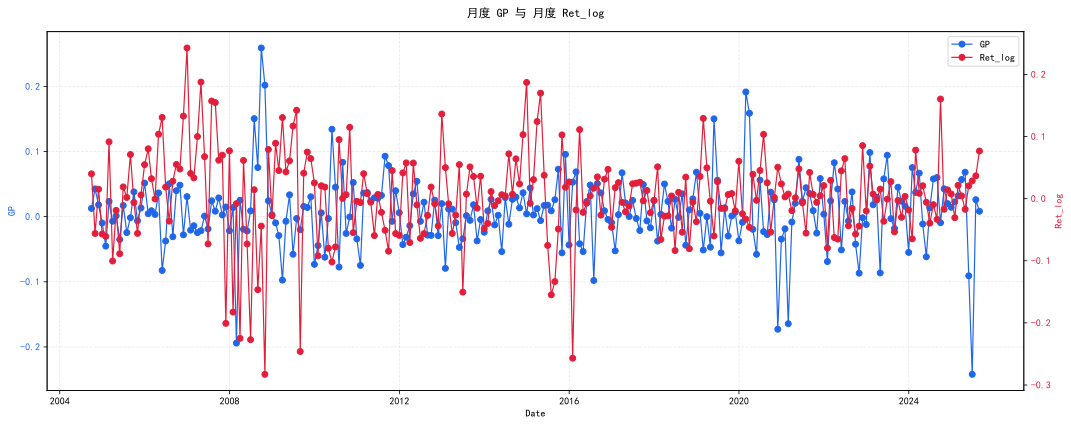

In [75]:
# 共享 x 轴的双 y 轴观察图
# 大致负关系
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置中文字体
plt.rcParams['axes.unicode_minus'] = False  #解决负号问题


# 双 y 轴绘图：左轴 GP，右轴 Ret_log，x 轴共享
fig, ax_left = plt.subplots(figsize=(15, 6))
color_left = '#1e66eaff'
color_right = '#e31e3b'

line_left, = ax_left.plot(aligned.index, aligned['GP'], color=color_left, marker='o',linewidth=1.2, label='GP')
ax_left.set_xlabel('Date')
ax_left.set_ylabel('GP', color=color_left)
ax_left.tick_params(axis='y', labelcolor=color_left)
ax_left.grid(True, linestyle='--', alpha=0.3)

ax_right = ax_left.twinx()
line_right, = ax_right.plot(aligned.index, aligned['Ret_log'], color=color_right, marker='o',linewidth=1.2, label='Ret_log')
ax_right.set_ylabel('Ret_log', color=color_right)
ax_right.tick_params(axis='y', labelcolor=color_right)

fig.suptitle('月度 GP 与 月度 Ret_log')

# 合并图例
lines = [line_left, line_right]
labels = [l.get_label() for l in lines]
ax_left.legend(lines, labels, loc='upper right')

plt.tight_layout()
aligned.head()
fig.savefig('图/monthlyGPandRet_log.pdf', bbox_inches='tight')

<h1 style="text-align:center; color:#e64500ff;">描述性统计</h1>

In [76]:
aligned[['GP','Ret_log']].describe().round(5)

,GP,Ret_log
count,252.00000,252.00000
mean,0.00702,0.00419
std,0.05475,0.07272
min,-0.24207,-0.28278
25%,-0.02078,-0.03011
50%,0.00867,0.00610
75%,0.03196,0.04168
max,0.25909,0.24253


In [77]:
aligned['Ret_log'].skew()#偏度
aligned['Ret_log'].kurt()#峰度

np.float64(-0.5469245162769671)

np.float64(2.609650092977513)

In [78]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月对数收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(aligned['Ret_log'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -5.0566
p-value: 0.0000
Critical Values:
   1%: -3.4582
   5%: -2.8738
   10%: -2.5733
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [79]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对黄金、铂金价格比率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(aligned['GP'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -6.1294
p-value: 0.0000
Critical Values:
   1%: -3.4576
   5%: -2.8735
   10%: -2.5731
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


<font size="6" color=#87CEEB>✨OLS 回归结果✨</font>  

In [80]:
#开始拟合月度数据（GP滞后一期）
monthly_reg = aligned[['Ret_log','GP']].copy()
monthly_reg['lGP'] = monthly_reg['GP'].shift(1)
monthly_reg = monthly_reg['2004-09-30':'2025-08-31'].dropna()
model_cpi = smf.ols('Ret_log ~ lGP',                      #smf.ols()调用包，'被解释变量 ~ 解释变量'
                 data=monthly_reg).fit(              #数据是什么，.fit拟合，cov_type='HAC', cov_kwds={'maxlags': 6}处理时间序列数据存在自相关或异方差问题
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())
#===== 回归结果主要结论 =====
#1. 模型整体不显著：F统计量p值=0.931 > 0.05，模型整体不显著
#2. 滞后黄金铂金价格比率不显著：lGP系数=-0.0118，p值=0.931 > 0.05，统计上不显著
#- 滞后一期黄金铂金价格比率变动对股票月收益率无显著预测能力
#3. 截距项不显著：截距系数=0.0041，p值=0.483 > 0.05，统计上不显著
#4. 模型解释力极弱：R²=0.000，调整后R²=-0.004，模型完全无解释力

                            OLS Regression Results                            
Dep. Variable:                Ret_log   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.007548
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.931
Time:                        00:09:15   Log-Likelihood:                 301.90
No. Observations:                 251   AIC:                            -599.8
Df Residuals:                     249   BIC:                            -592.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0041      0.006      0.701      0.4

<h1 style="text-align:center; color:#e64500ff;">再试试季度数据</h1>

In [81]:
# 计算季度 GP：对日度 GP 累加（等价于季度 ln(黄金/铂金) 的变动）
gp_quarter = gold['GP'].resample('QE').sum().to_frame(name='GP')

# 与季度上证指数 Ret_log 对齐（取交集并去缺失）
quarter_data = Month_data.resample('QE').last() 
aligned2 = gp_quarter.join(quarter_data, how='inner').dropna()
aligned2


,GP,Ret_log
Day,,
2004-09-30,0.012657,0.039907
2004-12-31,0.051315,-0.056987
2005-03-31,-0.028728,-0.100404
2005-06-30,-0.016334,0.018864
2005-09-30,0.012191,-0.006203
...,...,...
2024-09-30,0.108831,0.160338
2024-12-31,0.077314,0.007579
2025-03-31,0.111602,0.004461


Text(0.5, 0, 'Date')

Text(0, 0.5, 'GP')

Text(0, 0.5, 'Ret_log')

Text(0.5, 0.98, '季度 GP 与 季度 Ret_log')

,GP,Ret_log
Day,,
2004-09-30,0.012657,0.039907
2004-12-31,0.051315,-0.056987
2005-03-31,-0.028728,-0.100404
2005-06-30,-0.016334,0.018864
2005-09-30,0.012191,-0.006203


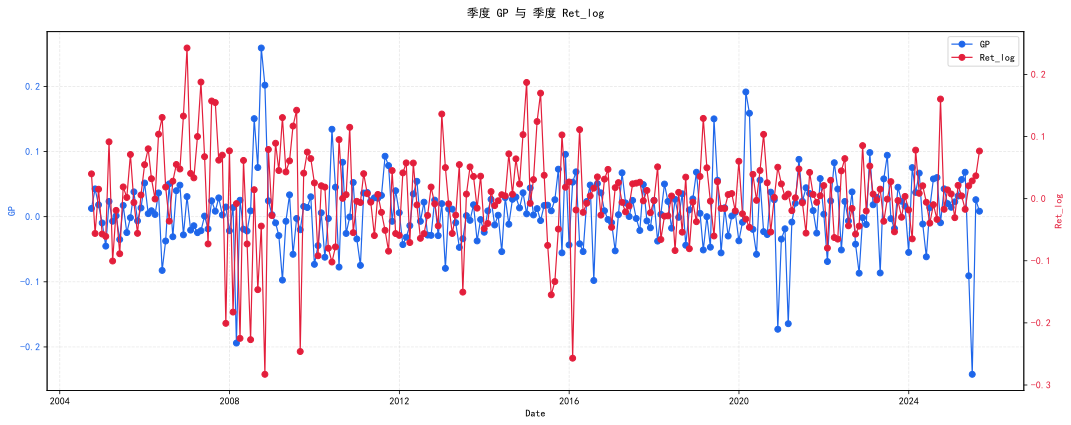

In [82]:
# 共享 x 轴的双 y 轴观察图
# 大致负关系
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置中文字体
plt.rcParams['axes.unicode_minus'] = False  #解决负号问题


# 双 y 轴绘图：左轴 GP，右轴 Ret_log，x 轴共享
fig, ax_left = plt.subplots(figsize=(15, 6))
color_left = '#1e66eaff'
color_right = '#e31e3b'

line_left, = ax_left.plot(aligned.index, aligned['GP'], color=color_left, marker='o',linewidth=1.2, label='GP')
ax_left.set_xlabel('Date')
ax_left.set_ylabel('GP', color=color_left)
ax_left.tick_params(axis='y', labelcolor=color_left)
ax_left.grid(True, linestyle='--', alpha=0.3)

ax_right = ax_left.twinx()
line_right, = ax_right.plot(aligned.index, aligned['Ret_log'], color=color_right, marker='o',linewidth=1.2, label='Ret_log')
ax_right.set_ylabel('Ret_log', color=color_right)
ax_right.tick_params(axis='y', labelcolor=color_right)

fig.suptitle('季度 GP 与 季度 Ret_log')

# 合并图例
lines = [line_left, line_right]
labels = [l.get_label() for l in lines]
ax_left.legend(lines, labels, loc='upper right')

plt.tight_layout()
aligned2.head()
fig.savefig('图/quarterlyGPandRet_log.pdf', bbox_inches='tight')

In [83]:
aligned2[['GP','Ret_log']].describe().round(5)

,GP,Ret_log
count,85.00000,85.00000
mean,0.02080,0.00365
std,0.10453,0.07465
min,-0.26457,-0.22700
25%,-0.02873,-0.04417
50%,0.01634,0.00446
75%,0.05923,0.03571
max,0.48519,0.24253


In [84]:
aligned2['Ret_log'].skew()#偏度
aligned2['Ret_log'].kurt()#峰度

np.float64(0.02331489647138813)

np.float64(2.220131752408665)

In [85]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月对数收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(aligned2['Ret_log'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -6.5489
p-value: 0.0000
Critical Values:
   1%: -3.5117
   5%: -2.8970
   10%: -2.5857
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [86]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对黄金、铂金价格比率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(aligned2['GP'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -8.2484
p-value: 0.0000
Critical Values:
   1%: -3.5117
   5%: -2.8970
   10%: -2.5857
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


<font size="6" color=#87CEEB>✨OLS 回归结果✨</font>  

<h1 style="text-align:center; color:#e64500ff;">再试试年度数据</h1>


In [87]:
# 计算年度 GP：对日度 GP 累加（等价于年度 ln(黄金/铂金) 的变动）
gp_year = gold['GP'].resample('YE').sum().to_frame(name='GP')

# 与年度上证指数 Ret_log 对齐（取交集并去缺失）
year_data = Month_data.resample('YE').last() 
aligned3 = gp_year.join(year_data, how='inner').dropna()
aligned3


,GP,Ret_log
Day,,
2004-12-31,0.063972,-0.056987
2005-12-31,0.025864,0.054696
2006-12-31,0.044777,0.242526
2007-12-31,-0.040715,0.076968
2008-12-31,0.527494,-0.027277
2009-12-31,-0.202656,0.025290
2010-12-31,0.074396,-0.004300
2011-12-31,0.323040,-0.059137
2012-12-31,-0.024165,0.136239


Text(0.5, 0, 'Date')

Text(0, 0.5, 'GP')

Text(0, 0.5, 'Ret_log')

Text(0.5, 0.98, '年度 GP 与 年度 Ret_log')

,GP,Ret_log
Day,,
2004-12-31,0.063972,-0.056987
2005-12-31,0.025864,0.054696
2006-12-31,0.044777,0.242526
2007-12-31,-0.040715,0.076968
2008-12-31,0.527494,-0.027277


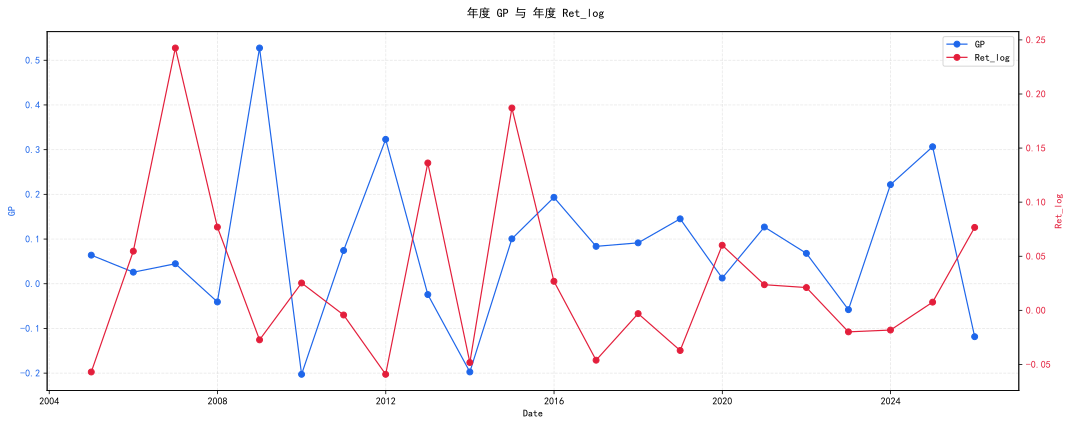

In [88]:
# 共享 x 轴的双 y 轴观察图
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置中文字体
plt.rcParams['axes.unicode_minus'] = False  #解决负号问题

# 双 y 轴绘图：左轴 GP，右轴 Ret_log，x 轴共享
fig, ax_left = plt.subplots(figsize=(15, 6))
color_left = '#1e66eaff'
color_right = '#e31e3b'

line_left, = ax_left.plot(aligned3.index, aligned3['GP'], color=color_left, marker='o',linewidth=1.2, label='GP')
ax_left.set_xlabel('Date')
ax_left.set_ylabel('GP', color=color_left)
ax_left.tick_params(axis='y', labelcolor=color_left)
ax_left.grid(True, linestyle='--', alpha=0.3)

ax_right = ax_left.twinx()
line_right, = ax_right.plot(aligned3.index, aligned3['Ret_log'], color=color_right, marker='o',linewidth=1.2, label='Ret_log')
ax_right.set_ylabel('Ret_log', color=color_right)
ax_right.tick_params(axis='y', labelcolor=color_right)

fig.suptitle('年度 GP 与 年度 Ret_log')

# 合并图例
lines = [line_left, line_right]
labels = [l.get_label() for l in lines]
ax_left.legend(lines, labels, loc='upper right')

plt.tight_layout()
aligned3.head()
fig.savefig('图/yearlyGPandRet_log.pdf', bbox_inches='tight')


In [89]:
aligned3[['GP','Ret_log']].describe().round(5)


,GP,Ret_log
count,22.00000,22.00000
mean,0.08037,0.02812
std,0.16908,0.07865
min,-0.20266,-0.05914
25%,-0.01495,-0.02543
50%,0.07118,0.01432
75%,0.14066,0.05881
max,0.52749,0.24253


In [90]:
aligned3['Ret_log'].skew()#偏度
aligned3['Ret_log'].kurt()#峰度


np.float64(1.3518258137881545)

np.float64(1.6821239264785337)

In [91]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对年度对数收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(aligned3['Ret_log'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')


原始序列的ADF检验结果:
ADF Statistic: -4.5749
p-value: 0.0001
Critical Values:
   1%: -3.8591
   5%: -3.0420
   10%: -2.6609
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [92]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对黄金、铂金价格比率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(aligned3['GP'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')


原始序列的ADF检验结果:
ADF Statistic: -2.5322
p-value: 0.1078
Critical Values:
   1%: -3.9240
   5%: -3.0685
   10%: -2.6739
结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。


<font size="6" color=#87CEEB>✨OLS 回归结果✨</font>


In [93]:
#开始拟合年度数据（GP滞后一期）
year_reg = aligned3[['Ret_log','GP']].copy()
year_reg['lGP'] = year_reg['GP'].shift(1)
year_reg = year_reg['2004-09-30':'2025-08-31'].dropna()
model_cpi = smf.ols('Ret_log ~ lGP',                      #smf.ols()调用包，'被解释变量 ~ 解释变量'
                 data=year_reg).fit(              #数据是什么，.fit拟合，cov_type='HAC', cov_kwds={'maxlags': 6}处理时间序列数据存在自相关或异方差问题
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())


                            OLS Regression Results                            
Dep. Variable:                Ret_log   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.053
Method:                 Least Squares   F-statistic:                   0.09514
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.761
Time:                        00:09:16   Log-Likelihood:                 22.785
No. Observations:                  20   AIC:                            -41.57
Df Residuals:                      18   BIC:                            -39.58
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0318      0.015      2.067      0.0

In [94]:
#开始拟合季度数据（GP滞后一期）
quarter_reg = aligned2[['Ret_log','GP']].copy()
quarter_reg['lGP'] = quarter_reg['GP'].shift(1)
quarter_reg = quarter_reg['2004-09-30':'2025-08-31'].dropna()
model_cpi = smf.ols('Ret_log ~ lGP',                      #smf.ols()调用包，'被解释变量 ~ 解释变量'
                 data=quarter_reg).fit(              #数据是什么，.fit拟合，cov_type='HAC', cov_kwds={'maxlags': 6}处理时间序列数据存在自相关或异方差问题
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())
#===== 回归结果主要结论 =====
#1. 模型整体不显著：F统计量p值=0.189 > 0.1，模型整体不显著
#2. 滞后黄金铂金价格比率不显著：IGP系数=0.0790，p值=0.186 > 0.1，统计上不显著
#- 滞后一期黄金铂金价格比率变动对股票季度收益率无显著预测能力
#3. 模型解释力极弱：R²=0.011，调整后R²=-0.001，模型几乎无解释力

                            OLS Regression Results                            
Dep. Variable:                Ret_log   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     1.751
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.189
Time:                        00:09:16   Log-Likelihood:                 98.195
No. Observations:                  83   AIC:                            -192.4
Df Residuals:                      81   BIC:                            -187.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.008      0.052      0.9

In [95]:
#最后再整合一个美观的合并表（全部使用滞后一期的GP，记作 lGP）
from statsmodels.iolib.summary2 import summary_col

# 日度模型：Log_return ~ lGP
daily_tbl = daily_aligned[['Log_return','GP']].copy()
daily_tbl['lGP'] = daily_tbl['GP'].shift(1)
daily_tbl = daily_tbl['2004-09-30':'2025-08-31'].dropna()
model_daily = smf.ols('Log_return ~ lGP',
                     data=daily_tbl).fit(
                         cov_type='HAC', cov_kwds={'maxlags': 6})

# 月度模型：Ret_log ~ lGP
monthly_tbl = aligned[['Ret_log','GP']].copy()
monthly_tbl['lGP'] = monthly_tbl['GP'].shift(1)
monthly_tbl = monthly_tbl['2004-09-30':'2025-08-31'].dropna()
model_monthly = smf.ols('Ret_log ~ lGP',
                       data=monthly_tbl).fit(
                           cov_type='HAC', cov_kwds={'maxlags': 6})

# 季度模型：Ret_log ~ lGP
quarterly_tbl = aligned2[['Ret_log','GP']].copy()
quarterly_tbl['lGP'] = quarterly_tbl['GP'].shift(1)
quarterly_tbl = quarterly_tbl['2004-09-30':'2025-08-31'].dropna()
model_quarterly = smf.ols('Ret_log ~ lGP',
                         data=quarterly_tbl).fit(
                             cov_type='HAC', cov_kwds={'maxlags': 6})

# 年度模型：Ret_log ~ lGP
yearly_tbl = aligned3[['Ret_log','GP']].copy()
yearly_tbl['lGP'] = yearly_tbl['GP'].shift(1)
yearly_tbl = yearly_tbl['2004-09-30':'2025-08-31'].dropna()
model_yearly = smf.ols('Ret_log ~ lGP',
                      data=yearly_tbl).fit(
                          cov_type='HAC', cov_kwds={'maxlags': 6})

# 合并四个模型的汇总结果
results_table = summary_col([model_yearly, model_quarterly, model_monthly, model_daily],
                           model_names=['年度数据', '季度数据', '月度数据', '日度数据'],
                           stars=True,
                           info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)),
                                      'R2': lambda x: "{:.4f}".format(x.rsquared)},
                           regressor_order=['const','lGP'])

print(results_table)


                 年度数据     季度数据     月度数据     日度数据  
--------------------------------------------------
lGP            -0.0229  0.0790   -0.0118  0.0259  
               (0.0742) (0.0597) (0.1355) (0.0199)
Intercept      0.0318** 0.0004   0.0041   0.0001  
               (0.0154) (0.0083) (0.0059) (0.0002)
R-squared      0.0022   0.0113   0.0001   0.0004  
R-squared Adj. -0.0532  -0.0009  -0.0039  0.0002  
N              20       83       251      4986    
R2             0.0022   0.0113   0.0001   0.0004  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


<font size="6" color=#87CEEB>✨结论✨</font>  

- 第一，无论是日收益率序列、月收益率还是季度收益率序列，GP序列与股票指数序列  
<font size="4" color=#e64500ff>不显著</font>。<font size="4" color=#e64500ff>在上证指数 000001的数据上，
GP不适合用于预测股票走势</font>  

- 第二，在单黄金、铂金收益率序列与股票指数序列也<font size="4" color=#e64500ff>不显著</font>不适合用于预测大盘。